# Grad-CAM Analysis: INP vs. CLIP

In [1]:
import sys
sys.path.append('.')
sys.path.append('..')
sys.path.append('../coco-caption')
import torch
import numpy as np
import matplotlib.pyplot as plt
import copy
import os
import matplotlib.cm as mpl_color_map
from sklearn import manifold
from models import Model
from dataloader import get_loader
from tqdm import tqdm
from PIL import Image
from torchvision.transforms import Compose, Resize, CenterCrop
from config import Constants
from PIL import Image

init COCO-EVAL scorer


In [2]:
def get_model_and_device(checkpoint_path, device=None, strict=True, new_opt_used_to_override={}, **kwargs):
    if device is None:
        if torch.cuda.is_available():
            device = torch.device('cuda')
        else:
            device = torch.device('cpu')
    elif type(device) is str:
        device = torch.device(device)
    else:
        raise ValueError()
    
    model = Model.load_from_checkpoint(
        checkpoint_path, 
        map_location=device,
        strict=strict,
        new_opt_used_to_override=new_opt_used_to_override
    )
    
    if 'rep' in model.get_opt()['feats']:
        model.captioner.backbone.Backbone_I.attnpool = torch.nn.AdaptiveAvgPool2d(output_size=(1, 1))
        
    model.eval()
    return model, device

def get_image_preprocess_func(model):
    opt = model.get_opt()
    assert model.captioner.backbone is not None, \
        'Please pass the `--with_backbones xxx` argument'
    
    assert 'i' in opt['modality'], \
        'The model does not take the image modality as the input'

    index_of_image_modality = opt['modality'].index('i')
    assert opt['with_backbones'][index_of_image_modality].strip(), \
        'The model does not have the image backbone'
    
    image_preprocess_func = model.captioner.backbone.get_preprocess_func('i')
    assert image_preprocess_func is not None, \
        'the `image_preprocess_func` is not provided by model.captioner.backbone'

    if 'clip' not in opt['with_backbones'][index_of_image_modality].strip():
        assert 'resnet' in opt['with_backbones'][index_of_image_modality].strip()
        # when extracting the features of ResNet, we follow the implementations in the package `pretrainedmodels`, 
        # that is, `image_preprocess_func = LoadTransformImage(pretrainedmodels.resnet101(pretrained='imagenet'), scale=0.875)`.
        # the `image_preprocess_func` above will first resize the short edge of a image to 256 (224 / 0.875), and then apply CenterCrop((224, 224)).
        # however in CLIP-ResNet, `image_preprocess_func` resizes the short edge of a image to 224 and them apply CenterCrop((224, 224)).

        # to make sure that the same image regions are fed into the image backbone,
        # we here modify the `image_preprocess_func` in ResNet, 
        # i.e., `image_preprocess_func` will resize the short edge of a image to 224 rather than 256.
        # this operation will absolutely affect the captioning results,
        # so it is only used in Grad-CAM visualization for the display consistency.
        fn_opts = {
            'input_size': [3, 224, 224], 
            'input_space': 'RGB', 
            'input_range': [0, 1], 
            'mean': [0.485, 0.456, 0.406], 
            'std': [0.229, 0.224, 0.225]
        }
        from pretrainedmodels.utils import LoadTransformImage
        image_preprocess_func = LoadTransformImage(fn_opts, scale=1.0)
    
    return image_preprocess_func


def get_pred_caption(model, device, loader, vid, specific_image_positions = [], **kwargs):
    batch = loader.dataset.get_specific_data_by_vid_and_cap_id(vid, 0, device=device)
    if len(specific_image_positions):
        batch['feats'] = [item[:, specific_image_positions] for item in batch['feats']]

    with torch.no_grad():
        outputs = model.translate_step(batch=batch, vocab=model.get_vocab(), assert_only_a_caption_per_video=True)
        pred_caption = outputs[vid][0]['caption']

    return pred_caption


def get_all_captions_of_a_vid(model, device, loader, vid, predict=True, print_info=True, **kwargs):
    all_captions = loader.dataset.get_preprocessed_gt_sentences_by_vid(vid, add_special_tokens=False)
    
    if predict:
        pred_caption = get_pred_caption(model, device, loader, vid)
        all_captions = [pred_caption] + all_captions
    
    if print_info:
        for i, cap in enumerate(all_captions):
            print('{:3d} {:s}'.format((i-1) if predict else i, cap))
    
    return all_captions

In [3]:
class CamExtractor():
    """
        Extracts cam features from the model
    """
    def __init__(self, model, target_layer='layer4'):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

    def save_gradient(self, grad):
        self.gradients = grad

    def _forward(self, x):
        """
            Does a forward pass on convolutions, hooks the function at given layer
        """
        conv_outputs = None
        for module_name, module in self.model._modules.items():
            if module is None:
                assert module_name != self.target_layer, f"{self.target_layer} is None in the image backbone"
                continue

            x = module(x)  # Forward
            if module_name == self.target_layer:
                x.register_hook(self.save_gradient)
                conv_outputs = x  # Save the convolution output on that layer
                
        return conv_outputs, x

    def forward(self, x):
        """
            Does a full forward pass on the backbone model
        """
        bsz, n_frames, *rest_shape = x.shape
        x = x.view(bsz * n_frames, *rest_shape)
        conv_outputs, out = self._forward(x)
        out = out.view(bsz, n_frames, -1)
        return conv_outputs, out

def gradcam(model, device, batch, size=224, target_layer='layer4', specific_word_positions=[], softmax=False):
    backbone = model.captioner.backbone.get_backbone('i')
    extractor = CamExtractor(backbone, target_layer=target_layer)
    index_of_image_modality = model.get_opt()['modality'].index('i')
    
    # Full forward pass
    # - image backbone
    preprocess_images = batch['feats'][index_of_image_modality]
    conv_outputs, image_feats = extractor.forward(preprocess_images)
    batch['feats'][index_of_image_modality] = image_feats
    # - captioner
    outputs = model.captioner(batch=batch, skip_backbone=True)
    
    # Gradient for backprop
    gradient = torch.zeros_like(outputs['logits'])
    assert batch['labels'].shape[1] == gradient.shape[1]
    for pos in range(batch['labels'].shape[1]):
        if len(specific_word_positions) and pos not in specific_word_positions:
            # in this case, we only backprop the gradients of specific words
            continue
        label_of_this_pos = batch['labels'][0, pos]
        if label_of_this_pos == Constants.PAD:
            break
        gradient[0, pos, label_of_this_pos] = 1
    
    # Zero grad
    for m in model.modules():
        m.zero_grad()

    # Backprop
    if not softmax:
        outputs['logits'].backward(gradient=gradient, retain_graph=True)
    else:
        tmp = torch.softmax(outputs['logits'], dim=-1)
        tmp.backward(gradient=gradient, retain_graph=True)

    # Get hooked gradients
    guided_gradients = extractor.gradients.data
    # Get convolution outputs
    conv_outputs = conv_outputs.data
    # Apply global average pooling (GAP) to gradient.
    grad_weights = torch.mean(guided_gradients, (2, 3), keepdim=True)
    # Linearly combine activations and GAP gradient weights.
    saliency_map = torch.sum(conv_outputs * grad_weights, 1, keepdim=True)
    # Apply ReLU.
    saliency_map = torch.clamp(saliency_map, min=0) # (n_frames, 1, 7, 7)

    cams = saliency_map.squeeze(1).cpu().numpy() # (n_frames, 7, 7)
    cams = (cams - np.min(cams)) / (np.max(cams) - np.min(cams)) # normalize to 0~1
    cams = np.uint8(cams * 255) # change to grayscale
    
    cams = [Image.fromarray(cam).resize((size, size), Image.BILINEAR) for cam in cams] # interpolate each cam
    cams = [np.uint8(cam) / 255 for cam in cams] # make values in the range of 0 to 1 again (to get heatmaps)
    
    return cams

def apply_colormap_on_image(org_im, activation, colormap_name='jet', alpha=0.4):
    """
        Apply heatmap on image
    Args:
        org_img (PIL img): Original image
        activation_map (numpy arr): Activation map (grayscale) 0-255
        colormap_name (str): Name of the colormap
    """
    # Get colormap
    color_map = mpl_color_map.get_cmap(colormap_name)
    no_trans_heatmap = color_map(activation)
    # Change alpha channel in colormap to make sure original image is displayed
    heatmap = copy.copy(no_trans_heatmap)
    heatmap[:, :, 3] = alpha
    heatmap = Image.fromarray((heatmap*255).astype(np.uint8))
    no_trans_heatmap = Image.fromarray((no_trans_heatmap*255).astype(np.uint8))

    # Apply heatmap on iamge
    heatmap_on_image = Image.new("RGBA", org_im.size)
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, org_im.convert('RGBA'))
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, heatmap)
    return no_trans_heatmap, heatmap_on_image

def show(images_to_show, title='', figsize=(15, 6), n_row=4, n_col=7):
    fig = plt.figure(figsize=figsize)
    if title:
        plt.title(title)

    for i in range(len(images_to_show)):
        ax = plt.subplot(n_row, n_col, i+1)
        ax.imshow(images_to_show[i])
        ax.set_yticks([])
        ax.set_xticks([])

    plt.subplots_adjust(wspace=0, hspace=0.05)
    plt.show()

In [4]:
 def run_analysis(
        model = None, 
        device = None, 
        loader = None,
        checkpoint_path = None, 
        backbone_name = 'resnet101', 
        all_frames_path = '../../../new_VC_data/MSRVTT/all_frames',
        text = None,
        vid = None, 
        cid = None,
        specific_image_positions = [],
        batch = None,
        images_basenames = None,
        original_images = None,
        cams = None,
        target_layer = 'layer4', 
        specific_word_positions = [], 
        softmax = False,
        heatmaps = None,
        figsize = (15, 6), 
        n_row = 4, 
        n_col = 7,
        only_return_model_info=False,
    ):
    if model is not None:
        assert device is not None
        assert loader is not None
        opt = model.get_opt()
    else:
        assert checkpoint_path is not None
        model, device = get_model_and_device(
            checkpoint_path=checkpoint_path,
            device=device,
            strict=False,
            new_opt_used_to_override={
                'with_backbones': [backbone_name] if not isinstance(backbone_name, list) else backbone_name, 
                'all_frames_path': all_frames_path
            }
        )
        opt = model.get_opt()
        image_preprocess_func = get_image_preprocess_func(model)
        # index_of_image_modality = opt['modality'].index('i')

        loader = get_loader(opt, 
            mode='test',
            not_shuffle=True, 
            is_validation=True, 
            image_preprocess_func=image_preprocess_func
        )
    
    if only_return_model_info:
        return model, device, loader

    if text is None:
        assert vid is not None    
        assert cid is not None
        all_captions = get_all_captions_of_a_vid(model, device, loader, vid, predict=True, print_info=True)
        text = all_captions[cid + 1]

    if batch is None:
        assert vid is not None
        batch = loader.dataset.get_specific_data_by_vid_and_cap_id(
            vid, 
            text=text, 
            load_original_images_to_visualize=True,
            device=device
        )
        images_basenames = batch.pop('images_basenames')
        original_images = batch.pop('original_images')

        if len(specific_image_positions):
            images_basenames = [item for i, item in enumerate(images_basenames) if i in specific_image_positions]
            original_images = [item for i, item in enumerate(original_images) if i in specific_image_positions]
            batch['feats'] = [item[:, specific_image_positions] for item in batch['feats']]

        transform = Compose([Resize(224), CenterCrop((224, 224))])
        for i in range(len(original_images)):
            original_images[i] = transform(original_images[i])
    else:
        assert images_basenames is not None
        assert original_images is not None
    
    if cams is None:
        cams = gradcam(model, device, batch, target_layer=target_layer, specific_word_positions=specific_word_positions, softmax=softmax)

    if heatmaps is None:
        heatmaps = []
        for ori, cam in zip(original_images, cams):
            _, heatmap = apply_colormap_on_image(ori, cam)
            heatmaps.append(heatmap)
    
    assert len(original_images) == len(cams)

    print(text)
    show(heatmaps, text, figsize=figsize, n_row=n_row, n_col=n_col)

    return model, device, loader, \
        text, batch, images_basenames, original_images, \
            cams, heatmaps

In [5]:
INP, device, loader1 = run_analysis(
    checkpoint_path = '../exps/MSRVTT/Transformer/diff_feats/R101_i/best.ckpt',
    backbone_name = 'resnet101',
    device = 'cpu',
    only_return_model_info=True
)

- The backbone for the modality i is resnet101


In [6]:
CLIP, _, loader2 = run_analysis(
    checkpoint_path = '../exps/MSRVTT/Transformer/diff_feats/RN101_i/best.ckpt',
    backbone_name = 'clip~RN101',
    device = 'cpu',
    only_return_model_info=True
)

- The backbone for the modality i is clip~RN101


spongebob squarepants blows bubbles


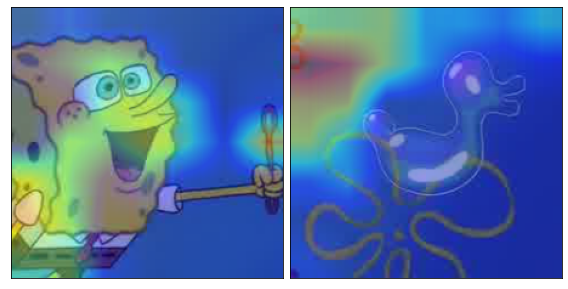

spongebob squarepants blows bubbles


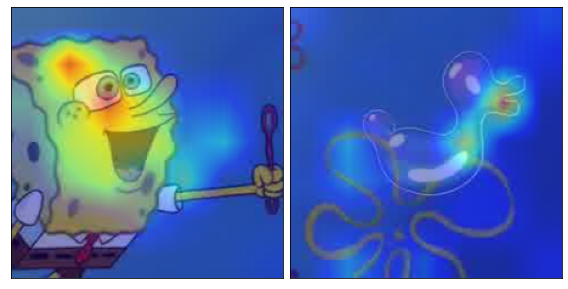

====== GT captions ======
  0 a cartoon character blows some bubbles
  1 a scene from the show called sponge bob
  2 a strange creature is created out of the water as patrick laughs and spongebob screams
  3 an anime is blowing some bubble and another anime is laughing at that
  4 patrick is laughing and spongebob is talking
  5 some animated characters are moving
  6 sponge bob blowing bubbles
  7 sponge bob squarepants blows a bubble and patrick laughs
  8 spongebob blows a bubble
  9 spongebob blows bubbles into a <unk> shape and patrick finds it funny
 10 spongebob is blowing bubbles
 11 spongebob is blowing bubbles
 12 spongebob squarepants blows bubbles
 13 spongebob squarepants is blowing bubbles into shapes to <unk> his friend
 14 <unk> blows animal soap bubbles
 15 the cartons games play
 16 two cartoon characters having a conversation underwater
 17 a strange creature is created out of the water as patrick laughs and spongebob screams
 18 <unk> blows animal soap bubbles
 19 s

In [7]:
other_inputs = {
    'vid': 'video9851',
    'text': 'spongebob squarepants blows bubbles',
    'specific_image_positions': [1, 6],
    'figsize': (10, 5),
    'n_row': 1,
    'n_col': 2,
}
_ = run_analysis(
    model = INP, device = device, loader = loader1,
    **other_inputs
)
_ = run_analysis(
    model = CLIP, device = device, loader = loader2,
    **other_inputs
)
print('====== GT captions ======')
get_all_captions_of_a_vid(INP, device, loader2, **other_inputs, predict=False)
print('====== Predictions ====== ')
print(get_pred_caption(INP, device, loader1, **other_inputs))
print(get_pred_caption(CLIP, device, loader2, **other_inputs))


a person with black and red dress is doing weight lifting


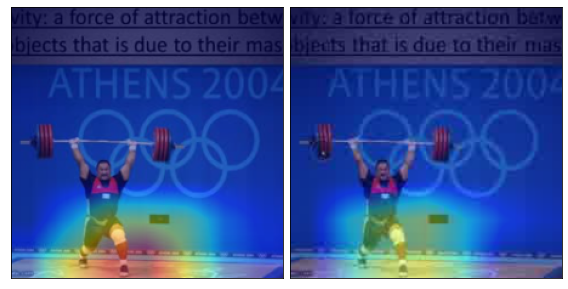

a person with black and red dress is doing weight lifting


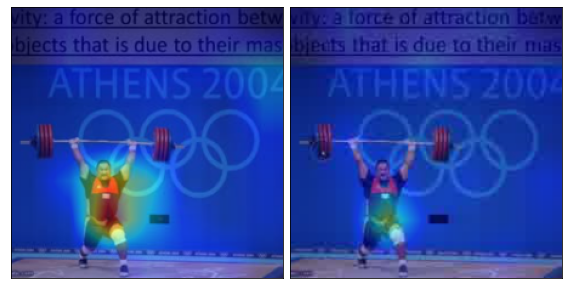

====== GT captions ======
  0 this video is about forces in physics including gravity which is an attractive force
  1 a man is standing on a stage lifting a large amount of weights in is hand
  2 the person talks about gravity and the weight lifter is fighting gravity in order to lift the weights
  3 a video presentation of a man showing the definition of gravity
  4 a weight lifter holds a set of weights above his head while a man discusses gravity
  5 a person is explaining about some sports events as weight lifting
  6 a force of attraction between objects that is due to their mass
  7 gravity is being explained with the help of an animation of a man weight lifting
  8 a heavy set weight lifter raises a <unk> heavy bar filled with weights
  9 an <unk> doing a heavy weight lifting in <unk> <unk> olympics
 10 a man is using picture of an olympic weight lifter to explain gravity
 11 weight lifting game where man lifts weight he wore dark dress
 12 a picture of a man in a red and blue 

In [8]:
other_inputs = {
    'vid': 'video7610',
    'text': 'a person with black and red dress is doing weight lifting',
    'specific_image_positions': [0, 27],
    'figsize': (10, 5),
    'n_row': 1,
    'n_col': 2,
}
_ = run_analysis(
    model = INP, device = device, loader = loader1,
    **other_inputs
)
_ = run_analysis(
    model = CLIP, device = device, loader = loader2,
    **other_inputs
)
print('====== GT captions ======')
get_all_captions_of_a_vid(INP, device, loader2, **other_inputs, predict=False)
print('====== Predictions ====== ')
print(get_pred_caption(INP, device, loader1, **other_inputs))
print(get_pred_caption(CLIP, device, loader2, **other_inputs))

there is a man slicing potato on the table


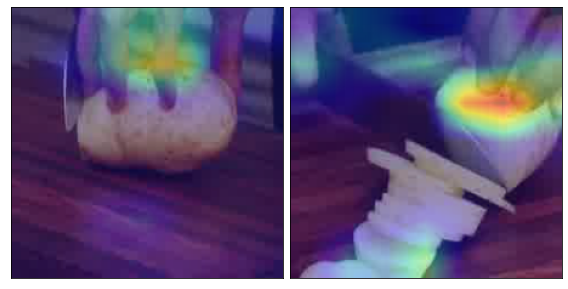

there is a man slicing potato on the table


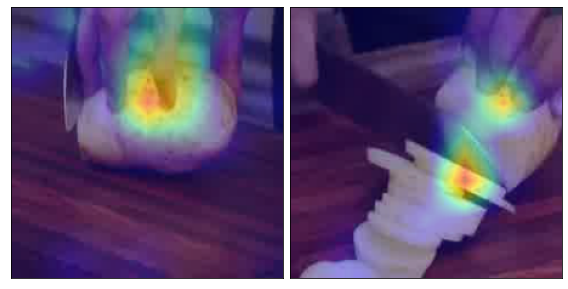

====== GT captions ======
  0 a man is demonstrating how to slice a potato <unk> using a knife and a cutting board
  1 a person is slicing a potato very <unk> on a counter
  2 there is a man slicing potato on the table
  3 the potato is being sliced into equal pieces with a sharp knife
  4 a man is doing a demonstration of himself slicing a potato into thin round chips
  5 a man slicing potatoes into pieces
  6 person slicing a potato with a into thing potato slices with a knife
  7 a man in a black hat slices a potato very <unk> with a knife on a wooden surface as he speaks in spanish
  8 a man is slicing a potato slowly on a dark wooden cutting board
  9 a man is slicing a potato very <unk>
 10 a person is slicing potatoes in very thin slices
 11 a person cutting a big potato on a wooden table
 12 a guy slicing the potato into very small slices using a big knife
 13 a man <unk> slices a potatoe into very thin slices
 14 some one is slicing potato in pieces on a table with the help of

In [9]:
other_inputs = {
    'vid': 'video7886',
    'text': 'there is a man slicing potato on the table',
    'specific_image_positions': [2, 21],
    'figsize': (10, 5),
    'n_row': 1,
    'n_col': 2,
}
_ = run_analysis(
    model = INP, device = device, loader = loader1,
    **other_inputs
)
_ = run_analysis(
    model = CLIP, device = device, loader = loader2,
    **other_inputs
)
print('====== GT captions ======')
get_all_captions_of_a_vid(INP, device, loader2, **other_inputs, predict=False)
print('====== Predictions ====== ')
print(get_pred_caption(INP, device, loader1, **other_inputs))
print(get_pred_caption(CLIP, device, loader2, **other_inputs))

a group of people are racing horses on a sunny day


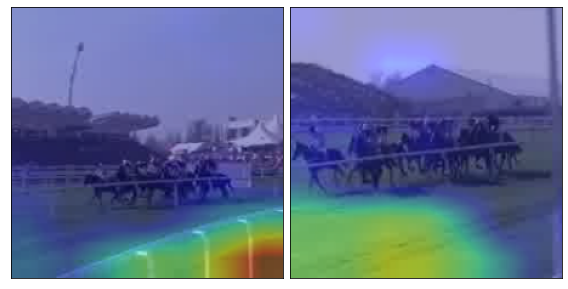

a group of people are racing horses on a sunny day


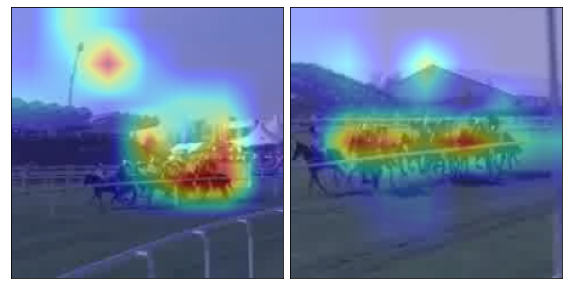

====== GT captions ======
  0 there is a man in white is riding a horse
  1 a man narrates while a group of horses with jockeys race on a grassy track
  2 horse race on the grass field all the jockey trying to make the horse run fast
  3 a group of horse riders riding the horse on the race
  4 horse race where number horses running on top man sit each horse has number
  5 horse <unk> let our and jockeys lay there <unk> low for <unk>
  6 a man is doing a play by play of a horse race
  7 a group of horses are racing down the pretty green and one horse is leading
  8 horses racing as one pulls ahead an announcer talks
  9 the crowd watches as a group of horses race with there riders
 10 a horse race on grass there is an announcer describing the position of the horses
 11 there is a horse race on a grass track with a british announcer describing the race
 12 group of people are riding their horses on the grass
 13 group of people are riding their horses on the grass
 14 a group of horses r

In [10]:
other_inputs = {
    'vid': 'video9973',
    'text': 'a group of people are racing horses on a sunny day',
    'specific_image_positions': [11, 20],
    'figsize': (10, 5),
    'n_row': 1,
    'n_col': 2,
}
_ = run_analysis(
    model = INP, device = device, loader = loader1,
    **other_inputs
)
_ = run_analysis(
    model = CLIP, device = device, loader = loader2,
    **other_inputs
)
print('====== GT captions ======')
get_all_captions_of_a_vid(INP, device, loader2, **other_inputs, predict=False)
print('====== Predictions ====== ')
print(get_pred_caption(INP, device, loader1, **other_inputs))
print(get_pred_caption(CLIP, device, loader2, **other_inputs))

a woman describing her shoes


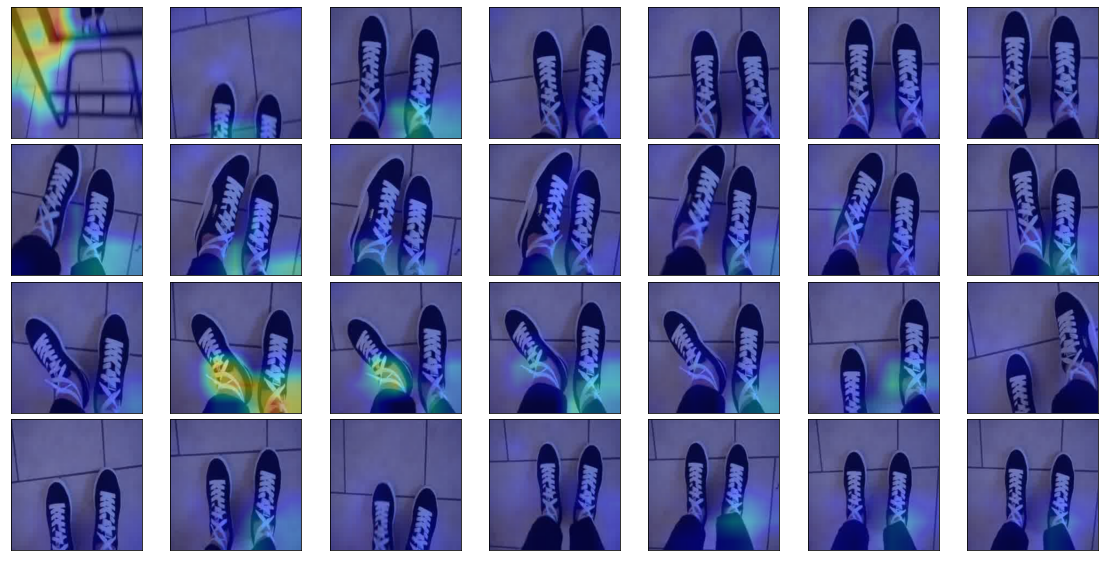

a woman describing her shoes


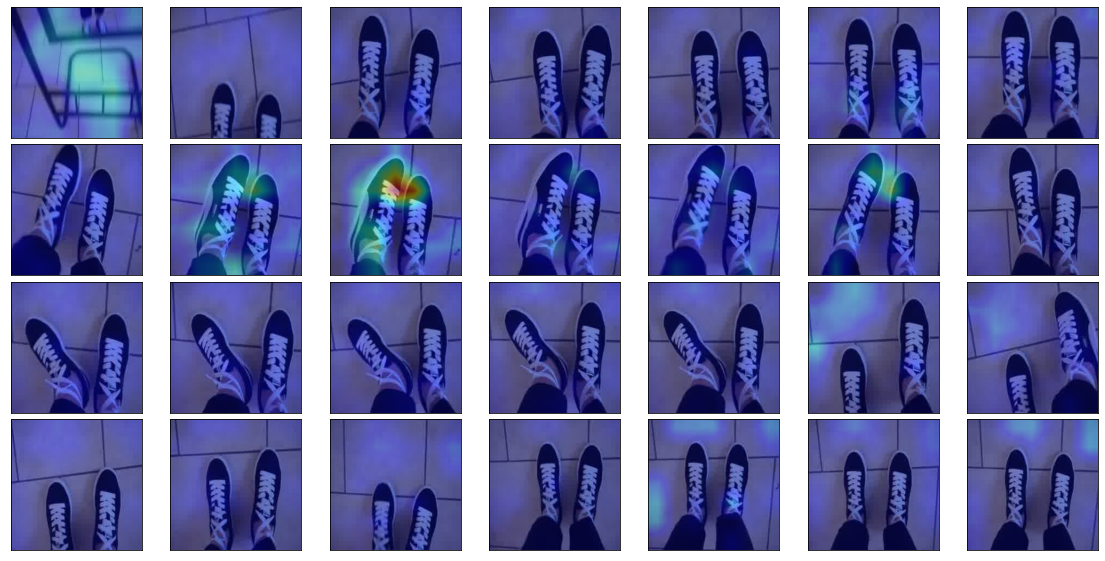

====== GT captions ======
  0 a female explains about the new shoes
  1 a girl films her shoes
  2 a girl gives a review for <unk> classic
  3 a pair of black and white sneakers are being <unk>
  4 a pair of tennis shoes is shown
  5 a person displaying their shoes
  6 a person is showing her black and white shoe and is talking about it
  7 a person records their new shoes
  8 a review of a pair of shoes
  9 a woman describing her shoes
 10 a woman displays her <unk> sneakers
 11 a woman gives a review of her new shoes
 12 a woman is talking
 13 a woman is talking about her shoes
 14 a woman wearing black and white sneakers
 15 a woman wearing <unk> shoes giving a review
 16 a young lady talks about the comfort and fashion of her <unk> brand sneakers
 17 girl shows off her new <unk> shoes
 18 someone is showing his shoe and talk about that
 19 someone is wearing black <unk> sneakers and showing them off
====== Predictions ====== 
a man is explaining how to use a computer program
a woma

In [11]:
other_inputs = {
    'vid': 'video8574',
    'text': 'a woman describing her shoes',
    'specific_image_positions': [],
    'figsize': (20, 10),
    'n_row': 4,
    'n_col': 7,
}
_ = run_analysis(
    model = INP, device = device, loader = loader1,
    **other_inputs
)
_ = run_analysis(
    model = CLIP, device = device, loader = loader2,
    **other_inputs
)
print('====== GT captions ======')
get_all_captions_of_a_vid(INP, device, loader2, **other_inputs, predict=False)
print('====== Predictions ====== ')
print(get_pred_caption(INP, device, loader1, **other_inputs))
print(get_pred_caption(CLIP, device, loader2, **other_inputs))

two men are wrestling on a mat


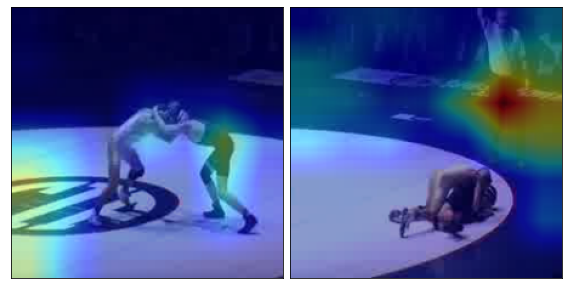

two men are wrestling on a mat


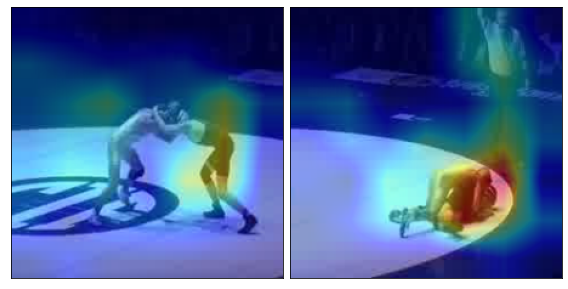

====== GT captions ======
  0 a wrestling match is going on
  1 fight of two people in a boxing ground
  2 guys in a olympic wrestling match
  3 men are doing wrestling
  4 people are greco wrestling
  5 there s two wrestlers on stage going at each other and the yellow one eventually over powers the other one
  6 two men are wrestling
  7 two men are wrestling
  8 two men are wrestling on a mat
  9 two men are wrestling
 10 two men competing in greco-roman wrestling for a competition
 11 two men in a wrestling match
 12 two men wrestle at a match
 13 two men wrestle in an amatuer event
 14 two men wrestling in an event in front of a crowd
 15 two people are wrestling
 16 two <unk> go at it in the ring
 17 two wrestlers grapple on a mat
 18 wrestling match between <unk> <unk> and paul fox
 19 two men are wrestling on a mat
====== Predictions ====== 
two men are wrestling in a competition
two wrestlers grapple on a mat


In [12]:
other_inputs = {
    'vid': 'video8823',
    'text': 'two men are wrestling on a mat',
    'specific_image_positions': [8, 21],
    'figsize': (10, 5),
    'n_row': 1,
    'n_col': 2,
}
_ = run_analysis(
    model = INP, device = device, loader = loader1,
    **other_inputs
)
_ = run_analysis(
    model = CLIP, device = device, loader = loader2,
    **other_inputs
)
print('====== GT captions ======')
get_all_captions_of_a_vid(INP, device, loader2, **other_inputs, predict=False)
print('====== Predictions ====== ')
print(get_pred_caption(INP, device, loader1, **other_inputs))
print(get_pred_caption(CLIP, device, loader2, **other_inputs))